# Dataset available at kaggle

https://www.kaggle.com/jonathanoheix/face-expression-recognition-dataset

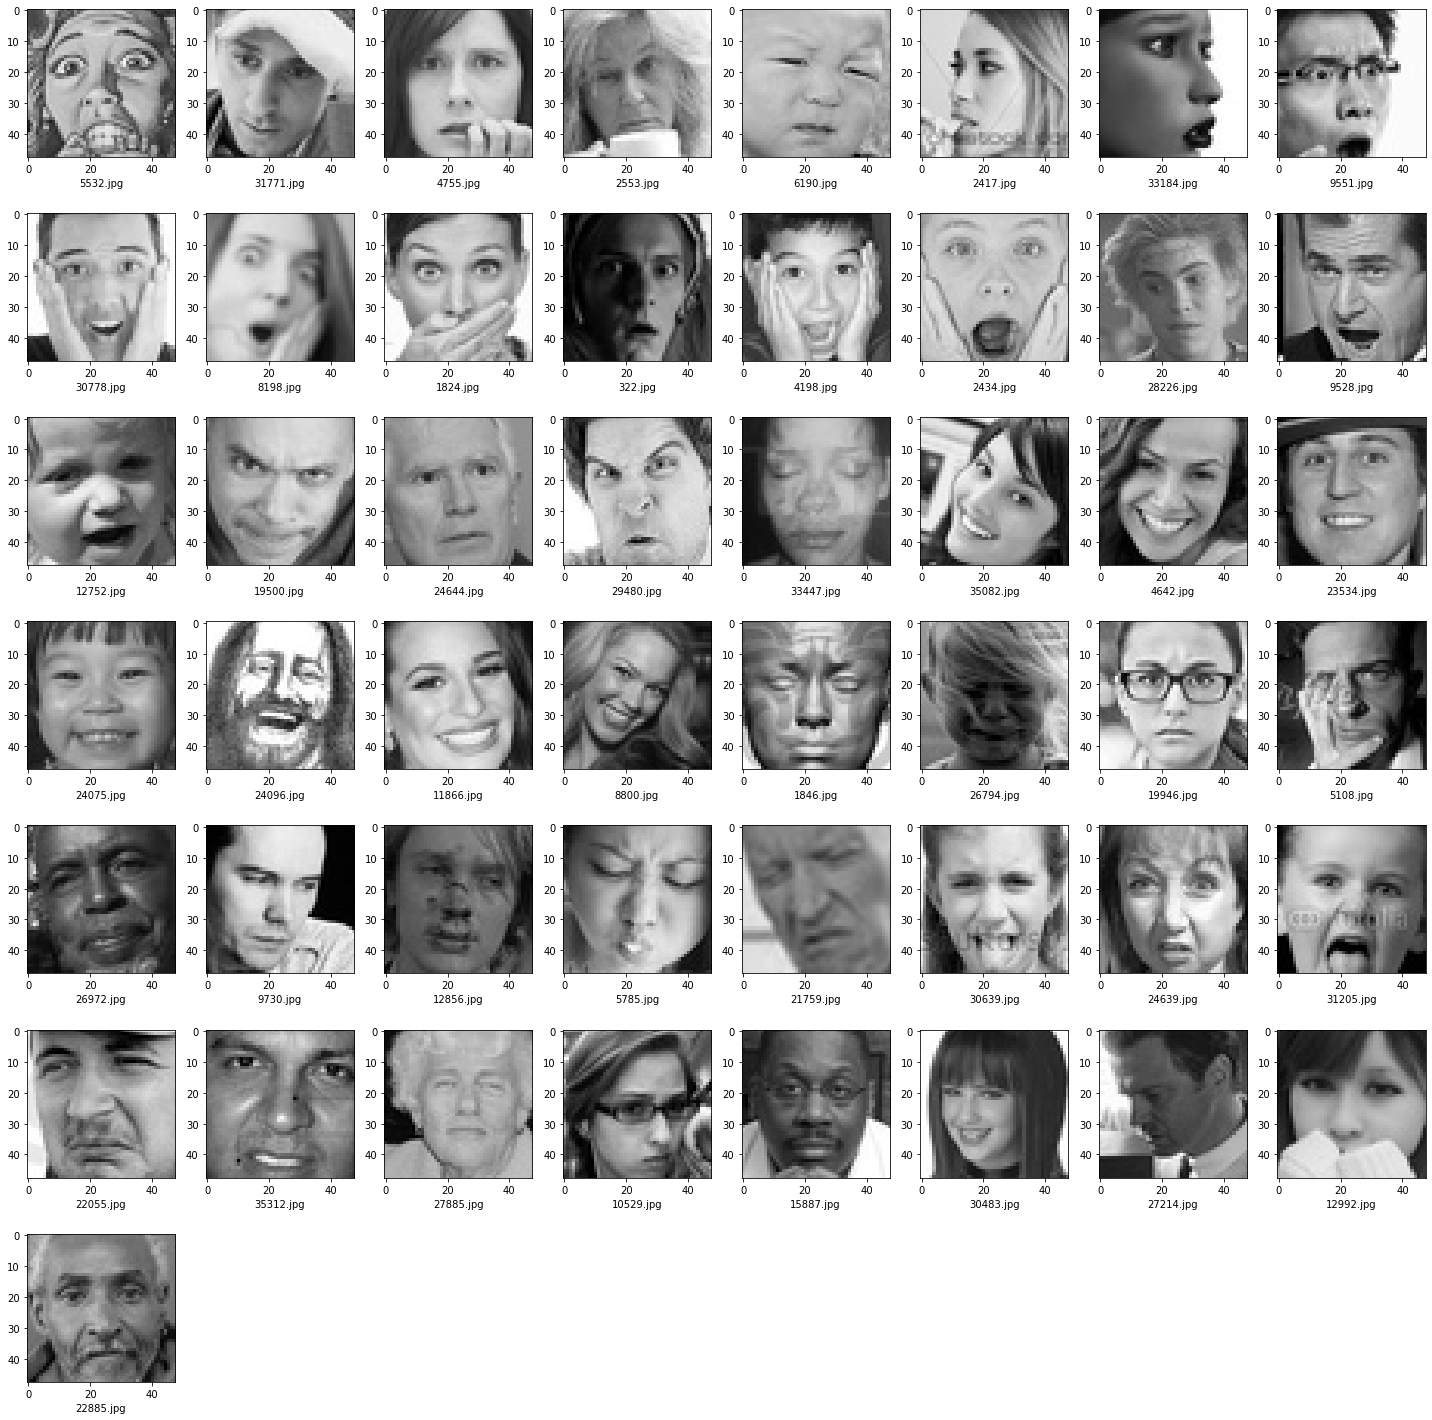

# Install libraries, packages and dataset

In [236]:
!git clone https://github.com/parth1620/Facial-Expression-Dataset.git
!pip install -U git+https://github.com/albumentations-team/albumentations
!pip install timm
!pip install --upgrade opencv-contrib-python

fatal: destination path 'Facial-Expression-Dataset' already exists and is not an empty directory.
  Cloning https://github.com/albumentations-team/albumentations to /tmp/pip-req-build-eswe6a3t
  Running command git clone --filter=blob:none --quiet https://github.com/albumentations-team/albumentations /tmp/pip-req-build-eswe6a3t
  Resolved https://github.com/albumentations-team/albumentations to commit 82818a0c4a80924d9f903a656c7f549ec6ca9cb2
  Preparing metadata (setup.py) ... done


# Imports

In [237]:
import numpy as np
import matplotlib.pyplot as plt
import torch

# Configurations

In [260]:
TRAIN_IMG_FOLDER = '/content/Facial-Expression-Dataset/train/'
VALID_IMG_FOLDER = '/content/Facial-Expression-Dataset/validation/'

LR = 0.001
BATCH_SIZE = 32
EPOCHS = 50

DEVICE = 'cuda'
MODEL_NAME = 'efficientnet_b3'

# Load Dataset

In [261]:
from torchvision.datasets import ImageFolder
from torchvision import transforms as T

In [262]:
train_augs = T.Compose([
    # T.Grayscale(), # Gives Weirdass colours
    T.RandomHorizontalFlip(p = 0.5),
    T.RandomRotation(degrees = (20, +20)),
    T.ToTensor() # PIL/numpy arr -> torch tensor -> (h, w, c) -> (c, h, w) [used by pytorch]
])

valid_augs = T.Compose([
    # T.Grayscale(), # Gives Weird ass colours
    T.ToTensor()
])

In [263]:
trainset = ImageFolder(TRAIN_IMG_FOLDER, transform = train_augs)
validset = ImageFolder(VALID_IMG_FOLDER, transform = valid_augs)

In [264]:
print(f"Total no. of examples in trainset : {len(trainset)}")
print(f"Total no. of examples in validset : {len(validset)}")

Total no. of examples in trainset : 28821
Total no. of examples in validset : 7066


In [265]:
print(trainset.class_to_idx)

{'angry': 0, 'disgust': 1, 'fear': 2, 'happy': 3, 'neutral': 4, 'sad': 5, 'surprise': 6}


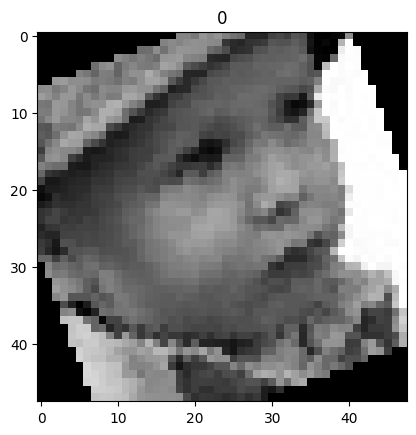

In [266]:
image, label = trainset[20]

plt.imshow(image.permute(1, 2, 0)) #(h, w, c) -> (c, h, w)
plt.title(label);

# Load Dataset into Batches

In [267]:
from torch.utils.data import DataLoader

In [268]:
trainloader = DataLoader(trainset, batch_size = BATCH_SIZE, shuffle = True)
validloader = DataLoader(validset, batch_size = BATCH_SIZE)


In [269]:
print(f"Total no. of batches in trainloader : {len(trainloader)}")
print(f"Total no. of batches in validloader : {len(validloader)}")

Total no. of batches in trainloader : 901
Total no. of batches in validloader : 221


In [270]:
for images, labels in trainloader:
  break

print(f"One image batch shape : {images.shape}")
print(f"One label batch shape : {labels.shape}")

One image batch shape : torch.Size([32, 3, 48, 48])
One label batch shape : torch.Size([32])


# Create Model

In [271]:
import timm
from torch import nn

In [272]:
class FaceModel(nn.Module):

  def __init__(self):
    super(FaceModel, self).__init__()

    self.eff_net = timm.create_model(MODEL_NAME, pretrained = True, num_classes = 7)
    # The output will be logits, without any Sigmoid or Softmaxx activation function

  def forward(self, images, labels = None):

    logits = self.eff_net(images)

    if labels != None:

      loss = nn.CrossEntropyLoss()(logits, labels)
      return logits, loss

    return logits


In [273]:
model = FaceModel()
model.to(DEVICE);

model.safetensors:   0%|          | 0.00/49.3M [00:00<?, ?B/s]

# Create Train and Eval Function

In [274]:
from tqdm import tqdm

In [275]:
def multiclass_accuracy(y_pred,y_true):
    top_p,top_class = y_pred.topk(1,dim = 1)
    equals = top_class == y_true.view(*top_class.shape)
    return torch.mean(equals.type(torch.FloatTensor))

In [276]:
def train_fn(model, dataloader, optimizer, current_epo):

  model.train()
  total_loss = 0.0
  total_acc = 0.0

  tk = tqdm(dataloader, desc = "EPOCH " + "[TRAIN]" + str(current_epo + 1) + " / " + str(EPOCHS))

  for t, data in enumerate(tk):
    images, labels = data
    images, labels = images.to(DEVICE), labels.to(DEVICE) # Literally wrote images instead of labels and wondered how everything is coming multiclass

    optimizer.zero_grad()
    logits, loss = model(images, labels)
    loss.backward()
    optimizer.step()

    total_loss += loss.item()
    total_acc += multiclass_accuracy(logits, labels)
    tk.set_postfix({'loss' : '%6f' %float(total_loss / (t+1)), 'acc' : '%6f' %float(total_acc / (t+1))})

    return total_loss / len(dataloader), total_acc / len(dataloader)

In [277]:
def valid_fn(model, dataloader, current_epo):

  model.eval()
  total_loss = 0.0
  total_acc = 0.0

  tk = tqdm(dataloader, desc = "EPOCH " + "[VALID]" + str(current_epo + 1) + " / " + str(EPOCHS))

  for t, data in enumerate(tk):
    images, labels = data
    images, labels = images.to(DEVICE), labels.to(DEVICE)

    logits, loss = model(images, labels)

    total_loss += loss.item()
    total_acc += multiclass_accuracy(logits, labels)
    tk.set_postfix({'loss' : '%6f' %float(total_loss / (t+1)), 'acc' : '%6f' %float(total_acc / (t+1))})

    return total_loss / len(dataloader), total_acc / len(dataloader)

# Create Training Loop

In [278]:
optimizer = torch.optim.Adam(model.parameters(), lr = LR)

In [279]:
best_valid_loss = np.Inf

for i in range(EPOCHS):
  train_loss, train_acc = train_fn(model, trainloader, optimizer, i)
  valid_loss, valid_acc = valid_fn(model, validloader, i)

  if valid_loss < best_valid_loss:
    torch.save(model.state_dict(), 'best_weights.pt')
    print("MODEL SAVED")
    best_valid_loss = valid_loss

EPOCH [VALID]1 / 50:   0%|          | 0/221 [00:00<?, ?it/s, loss=5.278643, acc=0.000000]


MODEL SAVED


EPOCH [VALID]2 / 50:   0%|          | 0/221 [00:00<?, ?it/s, loss=4.814316, acc=0.031250]


MODEL SAVED


EPOCH [VALID]3 / 50:   0%|          | 0/221 [00:00<?, ?it/s, loss=4.654670, acc=0.062500]


MODEL SAVED


EPOCH [VALID]49 / 50:   0%|          | 0/221 [00:00<?, ?it/s, loss=4.488752, acc=0.125000]


MODEL SAVED


EPOCH [VALID]50 / 50:   0%|          | 0/221 [00:00<?, ?it/s, loss=3.849902, acc=0.125000]


MODEL SAVED


# Inference

In [282]:
def view_classify(img, ps):

    classes = ['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']

    ps = ps.data.cpu().numpy().squeeze()
    img = img.numpy().transpose(1,2,0)

    fig, (ax1, ax2) = plt.subplots(figsize=(5,9), ncols=2)
    ax1.imshow(img)
    ax1.axis('off')
    ax2.barh(classes, ps)
    ax2.set_aspect(0.1)
    ax2.set_yticks(classes)
    ax2.set_yticklabels(classes)
    ax2.set_title('Class Probability')
    ax2.set_xlim(0, 1.1)

    plt.tight_layout()

    return None

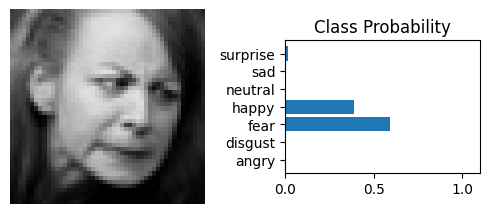

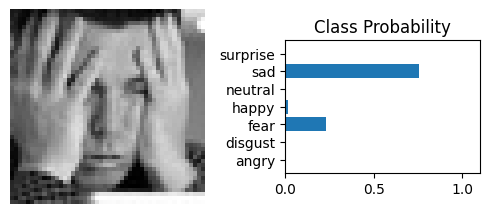

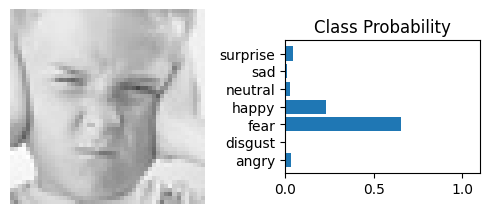

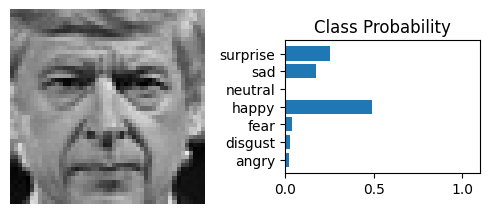

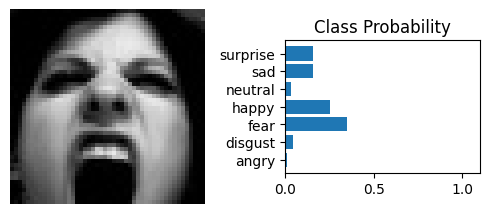

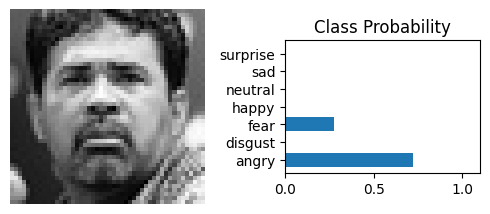

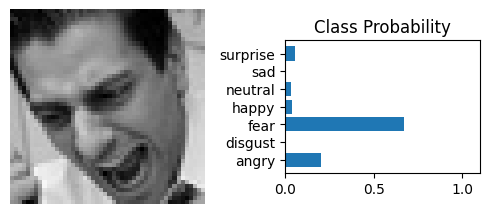

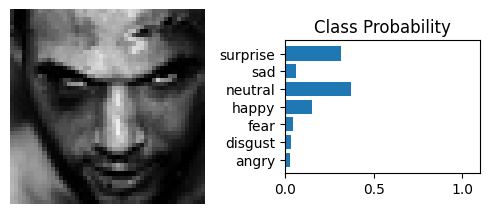

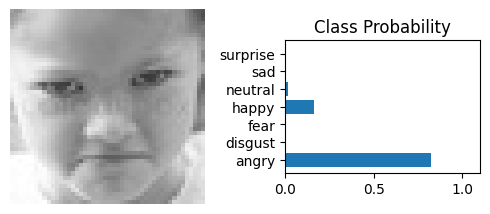

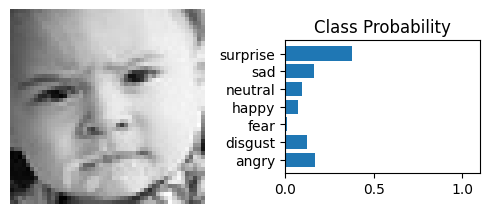

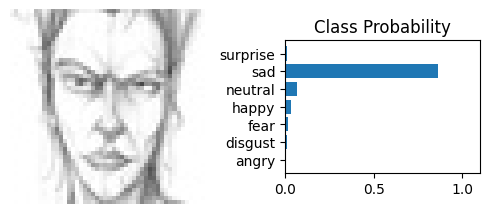

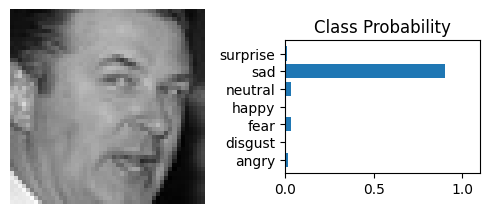

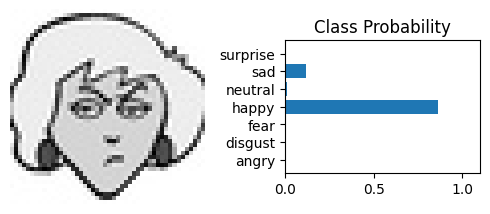

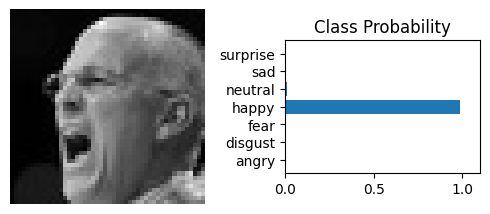

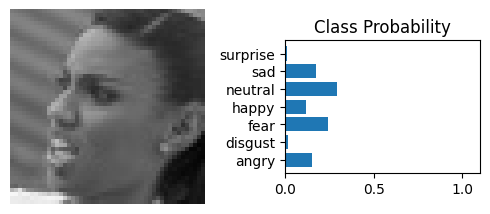

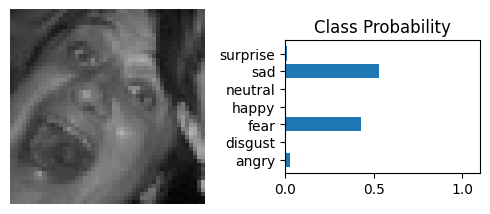

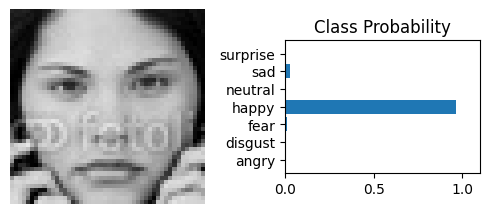

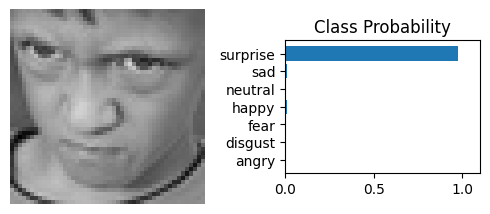

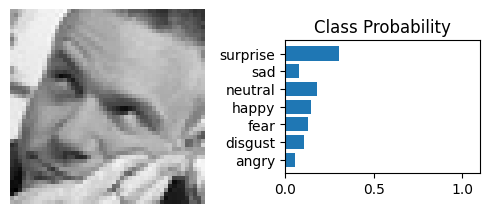

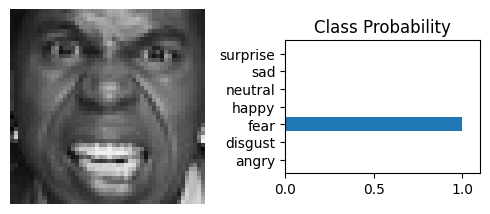

In [302]:
# Loading and initializing model with saved weights from training
model = FaceModel()
model.to(DEVICE)
model.load_state_dict(torch.load('/content/best_weights.pt'))
model.eval()

# Intereference from the image and visualisation
for data in validloader:
  break

# CASE = 0

for CASE in range(20):
  images, labels = data
  images, labels = images.to(DEVICE), labels.to(DEVICE)

  logits, loss = model(images, labels)
  m = nn.Softmax()
  logit = m(logits[CASE])
  imageDisplay = images[CASE].cpu()
  view_classify(imageDisplay, logit)




